### Tool Binding

[OpenAI Function calling](https://platform.openai.com/docs/guides/function-calling?api-mode=responses&example=get-weather) 참고
- OpenAI에서 제공하는 LLM은 함수를 호출해야 할 때를 감지한 후 함수를 호출하기 위한 인수가 포함된 JSON을 출력하도록 파인튜닝되어 있음

In [1]:
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm.invoke("오늘 서울 날씨가 어때?")

AIMessage(content='죄송하지만, 실시간 날씨 정보를 제공할 수는 없습니다. 서울의 현재 날씨를 확인하려면 기상청 웹사이트나 날씨 앱을 이용해 보시기 바랍니다. 도움이 필요하시면 다른 질문 해주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 15, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BO0uT92iJmJjRJnbaGyKzoX5U8Vvq', 'finish_reason': 'stop', 'logprobs': None}, id='run-f0d33342-7add-453a-ae91-5972e6baf39b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 51, 'total_tokens': 66, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

> LLM이 도구를 실행해주지는 않는다.

- 도구를 바인딩하고 모델을 호출하면, 답변을 위해 적절한 함수명과 params를 반환 

In [2]:
@tool
def get_weather(location: str) -> str:
    """Get the current weather in a given location"""
    return "오늘 서울 날씨는 맑아요"


tools = [get_weather]

llm_with_tools = llm.bind_tools(tools)

response = llm_with_tools.invoke("오늘 서울 날씨가 어때?")

print(response.tool_calls)

[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'call_1fRrJp5ihZ58y01fJhK7uxKd', 'type': 'tool_call'}]


In [3]:
toolbox = {"get_weather": get_weather}

tool_call = response.tool_calls[0]
tool_name = tool_call["name"]
tool_args = tool_call["args"]

result = toolbox[tool_name].invoke(tool_args)
print(result)

오늘 서울 날씨는 맑아요


### 1. Tranditional RAG

1. 벡터 DB 생성
    - 문서를 parsing -> chunking -> embedding -> saving on vector DB

In [4]:
import os
import warnings

from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pathlib import Path

warnings.filterwarnings("ignore")

BASE_DIR = Path("mcp_sample")
DATA_PATH = BASE_DIR / "data"
DB_PATH = BASE_DIR / "vector_store"
PERSISTANT_DIRECTORY = DB_PATH

os.makedirs(PERSISTANT_DIRECTORY, exist_ok=True)

loader = PyMuPDFLoader(DATA_PATH / "ai_brief.pdf")
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)

documents = loader.load()
chunks = splitter.split_documents(documents)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

if os.path.exists(PERSISTANT_DIRECTORY) and any(os.listdir(PERSISTANT_DIRECTORY)):
    print(f"Loading existing vector store: {PERSISTANT_DIRECTORY}")
    vector_store = Chroma(
        persist_directory=str(PERSISTANT_DIRECTORY),
        embedding_function=embeddings,
        collection_name="ai_trends",
    )
else:
    vector_store = Chroma.from_documents(
        documents=chunks,
        embedding=embeddings,
        collection_name="ai_trends",
        persist_directory=str(PERSISTANT_DIRECTORY),
    )

Loading existing vector store: mcp_sample/vector_store


In [5]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [8]:
retriever.ainvoke("Sean은 누구인가요?")

<coroutine object BaseRetriever.ainvoke at 0x7f041e737df0>

In [5]:
## 특이 케이스 추가 (테스트용)
from langchain_core.documents import Document

dummy_doc = Document(
    page_content="Sean은 LG CNS의 데이터 사이언티스트입니다. 소속 팀은 Customer AI Analytics팀이며, 4월 22일에 팀 정보공유회를 준비하고 있습니다. 최근에는 LLM 관련 프로젝트에 관심이 많으며, 일본의 영어 교육회사 AEON과 프로젝트를 진행하고 있습니다.",
    metadata={"page": 1211},
)

vector_store.add_documents([dummy_doc])

['e31655dc-cad6-4979-beee-b126740a94bb']

- Search

In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})


def format_docs(docs):
    result = []
    for i, doc in enumerate(docs):
        res = f"### 결과 {i+1}. Page : {doc.metadata['page']+1}\n"
        res += doc.page_content
        result.append(res)
    return "\n\n=========================\n\n".join(result)


# query = "젬마 3의 버전에는 어떤 것들이 있나요?"
query = "Sean은 누구인가요?"

result = retriever.invoke(query)
context = format_docs(result)

print(context[:200])

### 결과 1. Page : 1212
Sean은 LG CNS의 데이터 사이언티스트입니다. 소속 팀은 Customer AI Analytics팀이며, 4월 22일에 팀 정보공유회를 준비하고 있습니다. 최근에는 LLM 관련 프로젝트에 관심이 많으며, 일본의 영어 교육회사 AEON과 프로젝트를 진행하고 있습니다.




### 1. Tranditional RAG

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
ANSWER IN KOREAN. Be sure to cite the source page in your answer.
Question: {question} 
Context: {context} 
Answer:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

chain = (
    {"question": RunnablePassthrough(), "context": retriever | format_docs}
    | prompt
    | llm
    | StrOutputParser()
)

# chain.invoke({"question": query, "context": context})

In [8]:
# query = "젬마 3의 버전에는 어떤 것들이 있나요?"
query = "Sean은 누구인가요?"
print(chain.invoke(query))

Sean은 LG CNS의 데이터 사이언티스트로, Customer AI Analytics팀에 소속되어 있습니다. 그는 LLM 관련 프로젝트에 관심이 많으며, 일본의 영어 교육회사 AEON과 협력하고 있습니다. (출처: Page 1212)


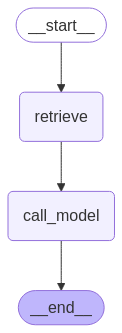

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]
    docs: Annotated[str, "Search Results"]


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
rag_chain = prompt | llm


def retrieve(state: State):
    query = state["messages"][0].content
    docs = retriever.invoke(query)
    return {"docs": format_docs(docs)}


def call_model(state: State):
    question = state["messages"][0].content
    context = state["docs"]
    response = rag_chain.invoke({"question": question, "context": context})
    return {"messages": [response]}


flow = StateGraph(State)

flow.add_node("retrieve", retrieve)
flow.add_node("call_model", call_model)

flow.add_edge(START, "retrieve")

flow.add_edge("retrieve", "call_model")
flow.add_edge("call_model", END)

memory = MemorySaver()

graph = flow.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# inputs = {"messages": [("user", "젬마 3의 버전에는 어떤 것들이 있나요?")]}
inputs = {"messages": [("user", "Sean은 누구인가요?")]}
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(inputs, config=config, stream_mode="updates")

for event in events:
    for k, v in event.items():
        if "messages" in v:
            print(v["messages"][-1].pretty_print())
        else:
            print(f"{k}: {v['docs']}")

retrieve: ### 결과 1. Page : 1212
Sean은 LG CNS의 데이터 사이언티스트입니다. 소속 팀은 Customer AI Analytics팀이며, 4월 22일에 팀 정보공유회를 준비하고 있습니다. 최근에는 LLM 관련 프로젝트에 관심이 많으며, 일본의 영어 교육회사 AEON과 프로젝트를 진행하고 있습니다.


### 결과 2. Page : 29
홈페이지 : https://spri.kr
보고서와 관련된 문의는 AI정책연구실(hs.lee@spri.kr, 031-739-7333)로 연락주시기 바랍니다.
경기도 성남시 분당구 대왕판교로 712번길 22 글로벌 R&D 연구동(B) 4층
22, Daewangpangyo-ro 712beon-gil, Bundang-gu, Seongnam-si, Gyeonggi-do, Republic of Korea, 13488


### 결과 3. Page : 4
제출하겠다고 발언 
∙레이쥔(雷軍) 샤오미(Xiaomi) CEO 겸 전인대 대표는 AI 기반 얼굴 합성과 음성 복제 기술의 남용 억제를 
강조하는 한편, 업계의 자정 노력 강화와 AI에 대한 대중 인식 제고를 촉구
∙정협 위원인 리징훙(李景虹) 칭화대(清华⼤) 교수는 인재 양성과 고용 보장, 국제 협력, 지식재산권 등 
광범위한 AI 문제를 포괄하는 AI 진흥법 도입을 제안
출처 | 中国政府网, 最全！50个动态场景看2025《政府⼯作报告》全⽂, 2025.03.05.
        Global Times, AI in spotlight at China's "two sessions", 2025.03.09.
================================== Ai Message ==================================

Sean은 LG CNS의 데이터 사이언티스트로, Customer AI Analytics팀에 소속되어 있습니다. 그는 LLM 관련 프로젝트에 관심이 많으며, 일본의 영어 교육회사 AEON과 협력하고 있습니다. (출처: Pag

## Tool로 줘보기

In [16]:
# LangChain 버전
from langchain_core.tools import tool


@tool
def retrieve_ai_trends(query: str) -> str:
    """Retrieve the latest trends in AI. If your question is related to AI trends, use this tool. This tool also contains information about a person named Sean. The query must be in Korean."""
    docs = retriever.invoke(query)
    return format_docs(docs)


@tool
def get_weather(location: str) -> str:
    """Provides the weather for a given location. The location must be in Korean."""
    if location == "서울":
        return "오늘 서울 날씨는 맑아요"
    else:
        return f"오늘 {location}은 바람이 심하게 불고 있습니다."


tools = [retrieve_ai_trends, get_weather]

llm_with_tools = llm.bind_tools(tools)

# response = llm_with_tools.invoke("젬마 3의 버전에는 어떤 것들이 있나요?")
response = llm_with_tools.invoke("Sean은 누구인가요?")
print(response.tool_calls)

response = llm_with_tools.invoke("오늘 서울의 날씨는 어떤가요?")
print(response.tool_calls)

[{'name': 'retrieve_ai_trends', 'args': {'query': 'Sean은 누구인가요?'}, 'id': 'call_30fbs8WFn9xbcKimTallwJ0G', 'type': 'tool_call'}]
[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'call_PHURHZTpYAYirGOtKDTpTFvW', 'type': 'tool_call'}]


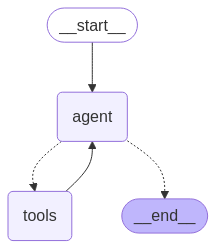

In [17]:
# LangGraph 버전
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import StreamWriter
from langchain_core.messages import AIMessage


class State(TypedDict):
    messages: Annotated[list, add_messages]


# 도구 정의
tools = [retrieve_ai_trends, get_weather]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def agent(state: State, writer: StreamWriter):
    messages = state["messages"]
    response = []
    tool_calls = None
    first = True

    for chunk in llm_with_tools.stream(messages):
        if chunk.tool_call_chunks:
            if first:
                tool_calls = chunk
                first = False
            else:
                tool_calls += chunk
        elif chunk.content:
            response.append(chunk.content)
            writer(chunk.content)
        else:
            continue
    if response:
        response = AIMessage(content="".join(response))
        if tool_calls:
            response.tool_calls = tool_calls.tool_calls
        return {"messages": [response]}
    else:
        return {"messages": [tool_calls]}


tool_node = ToolNode(tools=tools)


flow = StateGraph(State)
flow.add_node("agent", agent)
flow.add_node("tools", tool_node)

flow.add_edge(START, "agent")
flow.add_edge("tools", "agent")

flow.add_conditional_edges("agent", tools_condition)

memory = MemorySaver()
graph = flow.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
import uuid
import sys
from langchain_core.messages import HumanMessage

thread_id = str(uuid.uuid4())
config = {"recursion_limit": 10, "configurable": {"thread_id": thread_id}}


while True:
    user = input("User (q / Q to quit): ")

    print(f"User: {user}")

    if user in ["q", "Q"]:
        print("AI: 안녕히 계세요.")
        break

    output = None
    inputs = {"messages": [HumanMessage(content=user)]}
    first = True
    for chunk in graph.stream(inputs, config, stream_mode="custom"):
        if first:
            print("AI: ", end="")
            first = False
        if chunk:
            print(chunk, end="", flush=True)
    print()
    first = True
    if output and "generate_prompt" in output:
        print("Done!")

User: Sean은 누구인가요?
AI: Sean은 LG CNS의 데이터 사이언티스트로, Customer AI Analytics팀에 소속되어 있습니다. 그는 최근 LLM(대형 언어 모델) 관련 프로젝트에 관심을 가지고 있으며, 일본의 영어 교육회사 AEON과 프로젝트를 진행하고 있습니다.
User: q
AI: 안녕히 계세요.


In [19]:
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='Sean은 누구인가요?', additional_kwargs={}, response_metadata={}, id='f8a247bb-d165-4517-b8d9-f10d1ce66cae'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_5YCxCWrWTmLin1DKtmGFgSEw', 'function': {'arguments': '{"query":"Sean은 누구인가요?"}', 'name': 'retrieve_ai_trends'}, 'type': 'function'}]}, response_metadata={}, id='run-c3dcf747-07ef-4b2d-97dc-4edfdff2d9e0', tool_calls=[{'name': 'retrieve_ai_trends', 'args': {'query': 'Sean은 누구인가요?'}, 'id': 'call_5YCxCWrWTmLin1DKtmGFgSEw', 'type': 'tool_call'}]),
 ToolMessage(content='### 결과 1. Page : 1212\nSean은 LG CNS의 데이터 사이언티스트입니다. 소속 팀은 Customer AI Analytics팀이며, 4월 22일에 팀 정보공유회를 준비하고 있습니다. 최근에는 LLM 관련 프로젝트에 관심이 많으며, 일본의 영어 교육회사 AEON과 프로젝트를 진행하고 있습니다.\n\n=========================\n\n### 결과 2. Page : 29\n홈페이지 : https://spri.kr\n보고서와 관련된 문의는 AI정책연구실(hs.lee@spri.kr, 031-739-7333)로 연락주시기 바랍니다.\n경기도 성남시 분당구 대왕판교로 712번길 22 글로벌 R&D 연구동(B) 4층\n22, Daewangpangyo-ro 712beon-gil, Bundang-gu, Seongnam-si, Gyeo

### 3. MCP 활용하기
1. SSE 방식
    - 기존 FastAPI를 원격에서 서빙하고, 클라이언트가 호출하는 방식과 유사
    - mcp_server를 호스팅하고(여기서는 로컬서버), 애플리케이션을 sse 방식으로 연결

In [18]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

model = ChatOpenAI(model="gpt-4o")

async with MultiServerMCPClient(
    {
        # "math": {
        #     "command": "python",
        #     # Make sure to update to the full absolute path to your math_server.py file
        #     "args": ["/mcp_sample/mcp_server.py"],
        #     "transport": "stdio",
        # },
        "retrieve_ai_trends": {
            # make sure you start your weather server on port 8000
            "url": "http://localhost:4100/sse",
            "transport": "sse",
        }
    }
) as client:
    agent = create_react_agent(model, client.get_tools())
    async for event in agent.astream({"messages": "Sean은 누구인가요?"}):
        for k, v in event.items():
            if "messages" in v:
                print(v["messages"][-1].pretty_print())
            else:
                print(f"{k}: {v['docs']}")

================================== Ai Message ==================================
Tool Calls:
  retrieve_ai_trends (call_pyeCyeMU2ouvTZJOntYEiSJJ)
 Call ID: call_pyeCyeMU2ouvTZJOntYEiSJJ
  Args:
    query: Sean은 누구인가요?
None
================================= Tool Message =================================
Name: retrieve_ai_trends

### 결과 1. Page : 1212
Sean은 LG CNS의 데이터 사이언티스트입니다. 소속 팀은 Customer AI Analytics팀이며, 4월 22일에 팀 정보공유회를 준비하고 있습니다. 최근에는 LLM 관련 프로젝트에 관심이 많으며, 일본의 영어 교육회사 AEON과 프로젝트를 진행하고 있습니다.


### 결과 2. Page : 29
홈페이지 : https://spri.kr
보고서와 관련된 문의는 AI정책연구실(hs.lee@spri.kr, 031-739-7333)로 연락주시기 바랍니다.
경기도 성남시 분당구 대왕판교로 712번길 22 글로벌 R&D 연구동(B) 4층
22, Daewangpangyo-ro 712beon-gil, Bundang-gu, Seongnam-si, Gyeonggi-do, Republic of Korea, 13488


### 결과 3. Page : 4
제출하겠다고 발언 
∙레이쥔(雷軍) 샤오미(Xiaomi) CEO 겸 전인대 대표는 AI 기반 얼굴 합성과 음성 복제 기술의 남용 억제를 
강조하는 한편, 업계의 자정 노력 강화와 AI에 대한 대중 인식 제고를 촉구
∙정협 위원인 리징훙(李景虹) 칭화대(清华⼤) 교수는 인재 양성과 고용 보장, 국제 협력, 지식재산권 등 
광범위한 AI 문제를 포괄하는 AI 진흥법 도입을 제안
출처 | 中国政府网, 最全

In [19]:
client = MultiServerMCPClient(
    {
        "retrieve_ai_trends": {
            "url": "http://localhost:4100/sse",
            "transport": "sse",
        }
    }
)

await client.__aenter__()

print(client.get_tools())

# await client.__aexit__()

[StructuredTool(name='retrieve_ai_trends', description='Retrieve the latest trends in AI. If your question is related to AI trends, use this tool. This tool also contains information about a person named Sean. The query must be in Korean.', args_schema={'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'retrieve_ai_trendsArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x7f03b8113880>)]


Error in sse_reader: peer closed connection without sending complete message body (incomplete chunked read)


In [ ]:
agent = create_react_agent(model, client.get_tools())
async for event in agent.astream({"messages": "Sean은 누구인가요?"}):
    for k, v in event.items():
        if "messages" in v:
            print(v["messages"][-1].pretty_print())
        else:
            print(f"{k}: {v['docs']}")

================================== Ai Message ==================================

현재 서울의 날씨 정보를 확인할 수 없습니다. 날씨 정보를 얻으려면 날씨 관련 웹사이트나 앱을 참고하시기 바랍니다.
None
